<a href="https://colab.research.google.com/github/koukou10/dog_breed_image_classification/blob/master/Image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import shutil
import zipfile
from PIL import ImageFilter
from PIL import ImageOps
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from skimage import exposure
from skimage.feature import hog

np.random.seed(0)

Using TensorFlow backend.


In [0]:
def loadDF_Images(path):
    ''' Return dataframe with images names, dogs breeds, and type of set,
    it also returns 2 arrays of images, one of the training set and the other
    of the test set

    Parameter:

    path: location of the folder
    '''

    labels = []
    ids = []
    type_set = []
    loadedImages_train = []
    loadedImages_test = []

    for breed in os.listdir(path):
        nbr_imgs = len(os.listdir(path + breed))

        for idx, image in zip(range(nbr_imgs), os.listdir(path + breed)):
            labels.append(breed.split('-')[1])
            ids.append(image)
            train_len = int(0.8*nbr_imgs)

            if idx <= train_len - 1:
                type_set.append('training')
                img = Image.open(path + breed + '/'+ image)
                loadedImages_train.append(img)

            else:
                type_set.append('test')
                img = Image.open(path + breed + '/'+  image)
                loadedImages_test.append(img)

    df = pd.DataFrame({ 'Id': ids, 'Breed':labels, 'Type_set': type_set})

    return df, loadedImages_train, loadedImages_test    

In [0]:
path = '/content/gdrive/My Drive/Images/'
df, imgs_train, imgs_test = loadDF_Images(path)

In [5]:
df

,Id,Breed,Type_set
0,n02086079_21103.jpg,Pekinese,training
1,n02086079_14307.jpg,Pekinese,training
2,n02086079_11664.jpg,Pekinese,training
3,n02086079_10373.jpg,Pekinese,training
4,n02086079_884.jpg,Pekinese,training
5,n02086079_2368.jpg,Pekinese,training
6,n02086079_17983.jpg,Pekinese,training
7,n02086079_17103.jpg,Pekinese,training
8,n02086079_5053.jpg,Pekinese,training
9,n02086079_7302.jpg,Pekinese,training


In [6]:
breeds = list(df['Breed'].unique())
nbr_breeds = len(breeds)
print('Number of breeds: ', nbr_breeds)

Number of breeds:  120


# Image pre-processing

Mean width for train images is 442.40 px
Mean height for train images is 385.31 px


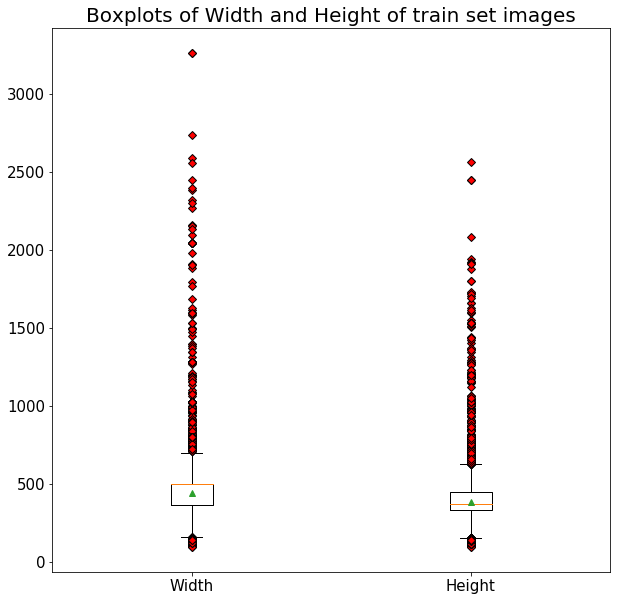

In [7]:
# Exploratory analysis of images size
# Boxplots of height and width

width_imgs_train = [img.size[0] for img in imgs_train]
height_imgs_train = [img.size[1] for img in imgs_train]
data = [width_imgs_train, height_imgs_train]
print('Mean width for train images is %.2f px' % np.mean(width_imgs_train))
print('Mean height for train images is %.2f px' % np.mean(height_imgs_train))

red_diamond = dict(markerfacecolor='r', marker='D')
fig, ax = plt.subplots(figsize=(10, 10))
plt.title("Boxplots of Width and Height of train set images", fontsize=20)
plt.xticks(size=15)
plt.yticks(size=15)
ax.boxplot(data, labels=['Width', 'Height'], flierprops=red_diamond, showmeans=True)
plt.show()


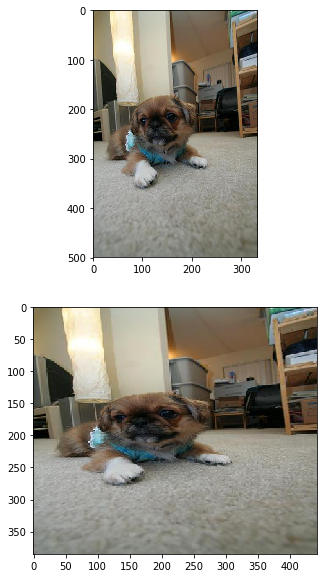

In [8]:
# Before/After (resize an image to 442x385 px)

STANDARD_SIZE = (442, 385) 
img = imgs_train[0]
new_img = img.resize(STANDARD_SIZE)

fig, ax = plt.subplots(figsize=(10, 10))
plt.figure(1)
plt.subplot(211)
plt.imshow(img)
plt.subplot(212)
plt.imshow(new_img)
plt.show()

In [0]:
# Normalize the data (resize each observation to 442x385 px)

STANDARD_SIZE = (442, 385) 
imgs_train = [img.resize(STANDARD_SIZE) for img in imgs_train]
imgs_test = [img.resize(STANDARD_SIZE) for img in imgs_test]

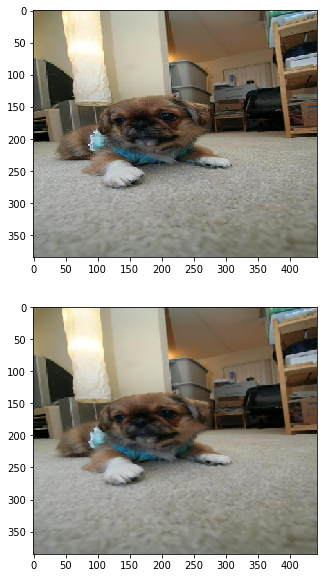

In [10]:
# 

img = imgs_train[0]
new_img = img.filter(ImageFilter.MedianFilter(size=3))

fig, ax = plt.subplots(figsize=(10, 10))
plt.figure(1)
plt.subplot(211)
plt.imshow(img)
plt.subplot(212)
plt.imshow(new_img)
plt.show()

In [0]:
def median_filter(image):
    '''Apply a median filter on the image

    Parameter:

        image: the image to filter
    '''

    img = image.filter(ImageFilter.MedianFilter(size=3))

    return img

In [0]:
# Applying equalization and median filter on training set images

imgs_train = [median_filter(img) for img in imgs_train]

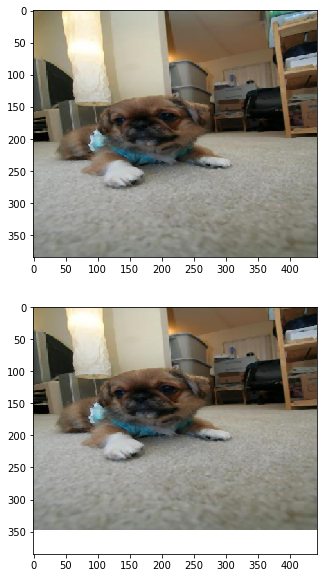

In [13]:
SHIFTING_UP = 38
HEIGHT = 385
WIDTH = 442
img = imgs_train[0]
new_img = np.array(img)

# Shifting Up (10% of height)
for j in range(WIDTH):
    for i in range(HEIGHT):
        if (i < HEIGHT - SHIFTING_UP):
            new_img[i][j] = new_img[i + SHIFTING_UP][j]
        else:
            new_img[i][j] = 255

new_img = Image.fromarray(new_img, 'RGB')

fig, ax = plt.subplots(figsize=(10, 10))
plt.figure(1)
plt.subplot(211)
plt.imshow(img)
plt.subplot(212)
plt.imshow(new_img)
plt.show()

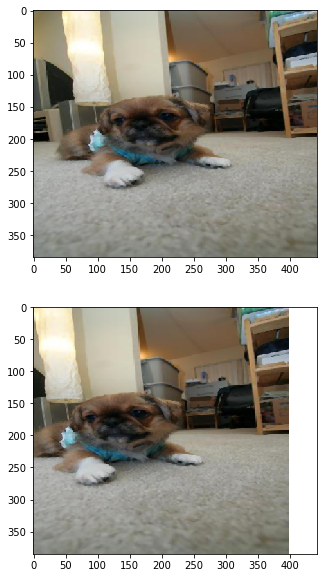

In [14]:
SHIFTING_LEFT = 44
img = imgs_train[0]
new_img = np.array(img)

# Shifting Left (10% of width)
for j in range(WIDTH):
    for i in range(HEIGHT):
        if (j < WIDTH - SHIFTING_LEFT):
            new_img[i][j] = new_img[i][j + SHIFTING_LEFT]
        else:
            new_img[i][j] = 255

new_img = Image.fromarray(new_img, 'RGB')

fig, ax = plt.subplots(figsize=(10, 10))
plt.figure(1)
plt.subplot(211)
plt.imshow(img)
plt.subplot(212)
plt.imshow(new_img)
plt.show()

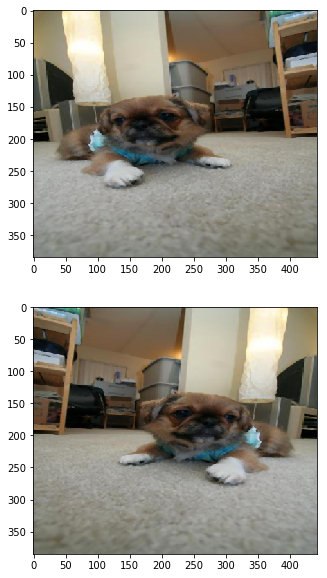

In [15]:
img = imgs_train[0]

# Flipping images
flipped_img = np.fliplr(img)
new_img = Image.fromarray(flipped_img, 'RGB')

fig, ax = plt.subplots(figsize=(10, 10))
plt.figure(1)
plt.subplot(211)
plt.imshow(img)
plt.subplot(212)
plt.imshow(new_img)
plt.show()

In [0]:
# Data augmentation (Flipping images, Shifting Left, Shifting Up)

HEIGHT = 385
WIDTH = 442
SHIFTING_LEFT = 44
SHIFTING_UP = 38
training_loc = np.where(df['Type_set']=='training')[0]

for idx, image in zip(training_loc, imgs_train):
    type_transf = np.random.randint(3)

    if type_transf == 0:
        # Flipping images
        flipped_img = np.fliplr(image)
        imgs_train.append(Image.fromarray(flipped_img, 'RGB'))
        df.loc[df.shape[0]] = [df['Id'][idx] + '-v2', df['Breed'][idx], df['Type_set'][idx]]

    if type_transf == 1:
        img = np.array(image)
        # Shifting Left (10% of width)
        for j in range(WIDTH):
            for i in range(HEIGHT):
                if (j < WIDTH - SHIFTING_LEFT):
                    img[i][j] = img[i][j + SHIFTING_LEFT]

                else:
                    img[i][j] = 255

        imgs_train.append(Image.fromarray(img, 'RGB'))
        df.loc[df.shape[0]] = [df['Id'][idx] + '-v2', df['Breed'][idx], df['Type_set'][idx]]

    if type_transf == 2:
        img = np.array(image)
        # Shifting Up (10% of height)
        for j in range(WIDTH):
            for i in range(HEIGHT):

                if (i < HEIGHT - SHIFTING_UP):
                    img[i][j] = img[i + SHIFTING_UP][j]

                else:
                    img[i][j] = 255

        imgs_train.append(Image.fromarray(img, 'RGB'))
        df.loc[df.shape[0]] = [df['Id'][idx] + '-v2', df['Breed'][idx], df['Type_set'][idx]]


In [0]:
# One hot encoding on the variable Breed

for breed in df['Breed'].unique():
    df[breed] = df['Breed'].str.contains(breed).apply(lambda x:1 if x else 0)

In [18]:
df

,Id,Breed,Type_set,Pekinese,wire,groenendael,Blenheim_spaniel,American_Staffordshire_terrier,cairn,Japanese_spaniel,English_foxhound,pug,Tibetan_terrier,beagle,kuvasz,briard,Rottweiler,Irish_wolfhound,Lhasa,malinois,komondor,West_Highland_white_terrier,toy_poodle,Pembroke,Ibizan_hound,Welsh_springer_spaniel,Doberman,French_bulldog,dingo,Irish_terrier,curly,Italian_greyhound,Labrador_retriever,Cardigan,Bedlington_terrier,chow,Norwich_terrier,Scottish_deerhound,Norwegian_elkhound,standard_poodle,...,Maltese_dog,schipperke,golden_retriever,Chesapeake_Bay_retriever,papillon,Brabancon_griffon,Sussex_spaniel,Yorkshire_terrier,Rhodesian_ridgeback,flat,whippet,Border_collie,Leonberg,affenpinscher,Siberian_husky,Lakeland_terrier,soft,dhole,Tibetan_mastiff,Irish_water_spaniel,bluetick,Shetland_sheepdog,boxer,Irish_setter,Newfoundland,kelpie,black,otterhound,miniature_schnauzer,redbone,Boston_bull,Mexican_hairless,African_hunting_dog,cocker_spaniel,Walker_hound,giant_schnauzer,Afghan_hound,Saluki,malamute,toy_terrier
0,n02086079_21103.jpg,Pekinese,training,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,n02086079_14307.jpg,Pekinese,training,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,n02086079_11664.jpg,Pekinese,training,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,n02086079_10373.jpg,Pekinese,training,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,n02086079_884.jpg,Pekinese,training,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,n02086079_2368.jpg,Pekinese,training,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,n02086079_17983.jpg,Pekinese,training,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,n02086079_17103.jpg,Pekinese,training,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,n02086079_5053.jpg,Pekinese,training,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,n02086079_7302.jpg,Pekinese,training,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Features extraction 

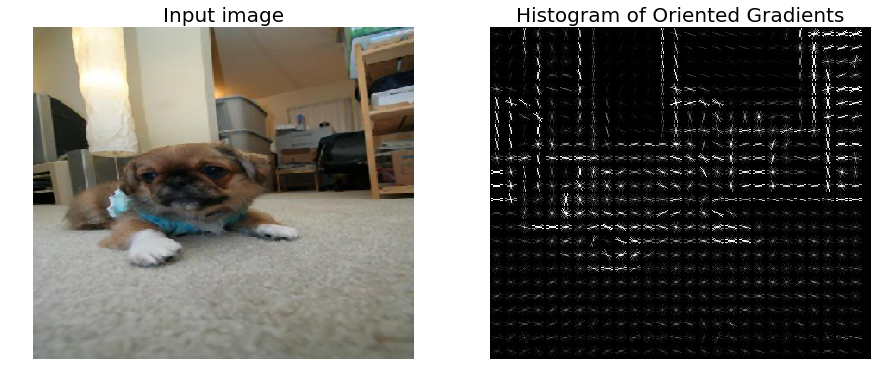

In [20]:
# Example of features extraction using HOG (Histogram of Oriented Gradients)

image = imgs_train[0]
fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, multichannel=True)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image', fontsize=20)

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients', fontsize=20)
plt.show()